In [1]:
%matplotlib inline

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedKFold

from yasf.layers.layers import InputLayer, LIFLayer, DaCLayer
from yasf.learning.learning import STDP, ncSTDP, ppxSTDP
from yasf.encoding.encoders import PoissonEncoder
from yasf.utils.data import DataWrapper
from yasf.utils.functions import normalize

def run_experiment(params):
    
    gpu = params["gpu"]
    
    device = torch.device("cuda:0" if torch.cuda.is_available() and gpu else "cpu")
    
    print(f"Running on device: {device}.")

    X, Y = load_iris(as_frame=False, return_X_y=True)

    X = torch.as_tensor(X, dtype=torch.float32)
    y = torch.as_tensor(Y, dtype=torch.int32)

    skf = StratifiedKFold(n_splits=5)

    #encoding arguments
    time = params["time"]
    dt = 1
    intensity = params["intensity"]

    #neuron arguments
    
    lsz = int(params["lsz"])
    
    neuronArgs = {"n":lsz, 
                  "rest":0, 
                  "reset":0, 
                  "thresh":params["thresh"], 
                  "refrac":params["refrac"],
                  "tc_decay":params["tc_decay"],
                  "dt":1,
                  "time":time,
                  "device":device,
                 }
    
    if params["plasticity"] != "stdp":
        neuronArgs["theta_plus"] = params["theta_plus"]
        neuronArgs["tc_theta_decay"] = 1e7
    

    #STDP arguments
    stdpArgs = params["stdpArgs"]

    #net args
    init_w = 0.1
    wmin = 0.
    wmax = 1.

    f1s = []
    Ps = []
    Ys = []

    for train_idx, test_idx in skf.split(X,Y):

        train_ds = DataWrapper(x=X[train_idx],
                               y=Y[train_idx],
                               sample_transform=PoissonEncoder(time=time, dt=dt, intensity=intensity),
                               target_transform=None,
                               global_transform=None,
                              )

        train_loader = DataLoader(train_ds, batch_size = 1, shuffle = True)

        test_ds = DataWrapper(x=X[test_idx],
                               y=Y[test_idx],
                               sample_transform=PoissonEncoder(time=time, dt=dt, intensity=intensity),
                               target_transform=None,
                               global_transform=None,
                              )

        test_loader = DataLoader(test_ds, batch_size = 1, shuffle = False)

        net_weights = init_w * torch.rand(X.shape[-1],lsz).to(device)
        rec_weights = -params["inh"] * (torch.ones(lsz, lsz) - torch.diag(torch.ones(lsz))).to(device)

        input_layer = InputLayer(n = X.shape[-1], dt = dt, time = time, device = device)
        
        if params["plasticity"] == "stdp":
            class_layer = LIFLayer(**neuronArgs)
        else:
            class_layer = DaCLayer(**neuronArgs)

        if params["plasticity"] == "ppx":
            stdp = ppxSTDP()
        elif params["plasticity"] == "nc":
            stdp = ncSTDP()
        elif params["plasticity"] == "stdp":
            stdp = STDP(**stdpArgs)

        train_samples = []
        train_labels = []
        test_samples = []
        test_labels = []
        
        for epoch in range(int(params["n_epochs"])):

            for batch in tqdm(train_loader):


                spike_recorder = torch.zeros(lsz).to(device)

                #run simulation
                for ts in range(int(time/dt)):

                    sample_spikes = batch[0].squeeze()[ts,:].to(device)

                    input_spikes, input_times = input_layer(sample_spikes)
                    output_spikes, output_times = class_layer(input_spikes, 
                                                              w = net_weights,
                                                              w_rec = rec_weights,
                                                             )
                    if params["plasticity"] == "stdp":
                        dw = stdp(input_times, output_times)
                    else:
                        dw = stdp(input_times, output_times, net_weights)

                    net_weights+=dw

                    #clamp weights
                    net_weights[net_weights < wmin] = wmin
                    net_weights[net_weights > wmax] = wmax

                    #normalize weights
                    net_weights = normalize(net_weights, params["norm"])

                    #print(torch.min(net_weights), torch.max(net_weights), torch.mean(net_weights))
                    spike_recorder+=output_spikes

                spike_recorder /= int(time/dt)

                if device == torch.device("cuda:0"):
                    spike_recorder = spike_recorder.cpu()
                    
                if epoch + 1 == int(params["n_epochs"]):

                    train_samples.append(spike_recorder.numpy())
                    train_labels.append(batch[1].squeeze().numpy())

                input_layer.reset_state()
                class_layer.reset_state()

        for batch in tqdm(test_loader):

            spike_recorder = torch.zeros(lsz).to(device)

            #run simulation
            for ts in range(int(time/dt)):
                input_spikes, input_times = input_layer(batch[0].squeeze()[ts,:].to(device))
                output_spikes, output_times = class_layer(input_spikes, 
                                                          w = net_weights,
                                                          w_rec = rec_weights,
                                                         )
                spike_recorder+=output_spikes

            spike_recorder /= int(time/dt)
            
            if device == torch.device("cuda:0"):
                spike_recorder = spike_recorder.cpu()

            test_samples.append(spike_recorder.numpy())
            test_labels.append(batch[1].squeeze().numpy())

            input_layer.reset_state()
            class_layer.reset_state()

        gbc = LogisticRegression(C=1e3)

        gbc.fit(train_samples, train_labels)
        
        preds = gbc.predict(test_samples)
        
        f1 = f1_score(test_labels, preds, average='macro')
        
        f1s.append(f1)
        Ps.append(preds)
        Ys.append(test_labels)
        
        print(f"F1-score is: {np.round(f1,2)}")
    
    return f1s, Ps, Ys

Running on device: cuda:0.


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:08<00:00,  3.51it/s]


F1-score is: 0.84


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.25it/s]


F1-score is: 0.87


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.13it/s]


F1-score is: 0.76


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.93it/s]


F1-score is: 0.93


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.98it/s]


F1-score is: 0.83


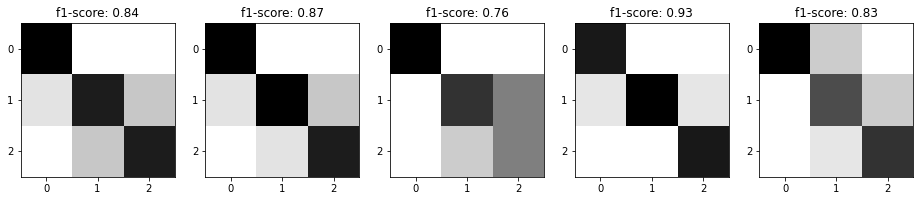

In [2]:
#regular stdp parameters

regular_stdp_pars = {
    "plasticity":"stdp",
    
    "stdpArgs":{
        "A_plus": 0.005,
        "A_minus" : 0.005,
        "tau_plus": 27.44,
        "tau_minus": 27.44,
    },
    
    "inh": 77.78, 
    "intensity": 88.98, 
    "norm": 6.94, 
    "refrac": 4.71, 
    "tc_decay": 147.96, 
    "thresh": 7.57,
    "gpu": True,
    "n_epochs":1,
    "time":300,
    "lsz":1600,
}

f1s, Ps, Ys = run_experiment(regular_stdp_pars)

fig = plt.figure(figsize=(16,6))

headings = [f"f1-score: {np.round(f1,2)}" for f1 in f1s]
data = [confusion_matrix(y,p) for y,p in zip(Ps,Ys)]

columns = len(f1s)
rows = 1

ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    ax[-1].set_xticks([0,1,2])
    ax[-1].set_yticks([0,1,2])
    plt.imshow(data[i-1], cmap='binary')
    ax[-1].set_title(headings[i-1])
plt.show()

Running on device: cuda:0.


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.28it/s]


F1-score is: 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.06it/s]


F1-score is: 0.83


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.05it/s]


F1-score is: 0.9


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.97it/s]


F1-score is: 0.86


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.09it/s]


F1-score is: 0.97


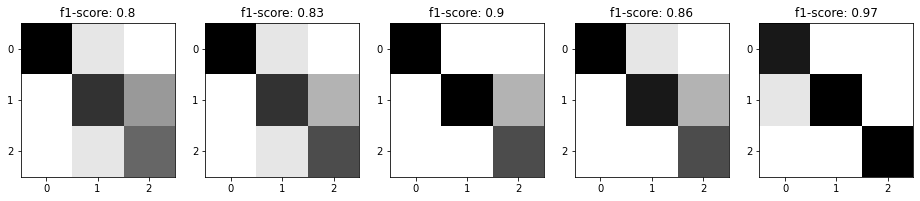

In [10]:
#ppx stdp parameters

ppx_stdp_pars = {
    "plasticity":"ppx",
    "stdpArgs":None,#no plasticity parameters required -- using default
    "inh": 61.61, 
    "intensity": 100.00, 
    "norm": 30.20, 
    "refrac": 14.71, 
    "tc_decay": 52.04, 
    "thresh": 12.71,
    "theta_plus": 0.027,
    "gpu": True,
    "n_epochs":1,
    "time":300,
    "lsz":1600,
}

f1s, Ps, Ys = run_experiment(ppx_stdp_pars)

fig = plt.figure(figsize=(16,6))

headings = [f"f1-score: {np.round(f1,2)}" for f1 in f1s]
data = [confusion_matrix(y,p) for y,p in zip(Ps,Ys)]

columns = len(f1s)
rows = 1

ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    ax[-1].set_xticks([0,1,2])
    ax[-1].set_yticks([0,1,2])
    plt.imshow(data[i-1], cmap='binary')
    ax[-1].set_title(headings[i-1])
plt.show()


Running on device: cuda:0.


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.05it/s]


F1-score is: 0.75


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.93it/s]


F1-score is: 0.76


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.16it/s]


F1-score is: 0.68


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.12it/s]


F1-score is: 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:09<00:00,  3.11it/s]


F1-score is: 0.84


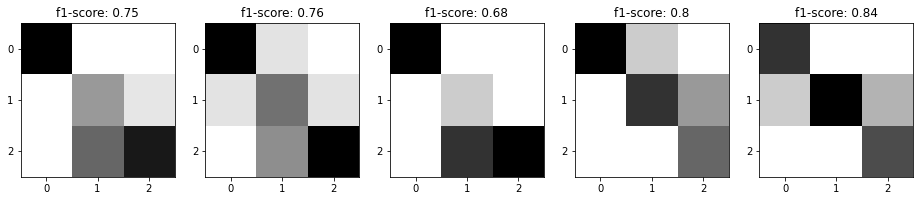

In [11]:
#nc stdp parameters

nc_stdp_pars = {
    "plasticity":"ppx",
    "stdpArgs":None,#no plasticity parameters required -- using default
    "inh": 17.16, 
    "intensity": 88.98, 
    "norm": 51.53, 
    "refrac": 8.43, 
    "tc_decay": 125.51, 
    "thresh": 14.43,
    "theta_plus": 0.035,
    "gpu": True,
    "n_epochs":1,
    "time":300,
    "lsz":1600,
}

f1s, Ps, Ys = run_experiment(nc_stdp_pars)

fig = plt.figure(figsize=(16,6))

headings = [f"f1-score: {np.round(f1,2)}" for f1 in f1s]
data = [confusion_matrix(y,p) for y,p in zip(Ps,Ys)]

columns = len(f1s)
rows = 1

ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    ax[-1].set_xticks([0,1,2])
    ax[-1].set_yticks([0,1,2])
    plt.imshow(data[i-1], cmap='binary')
    ax[-1].set_title(headings[i-1])
plt.show()

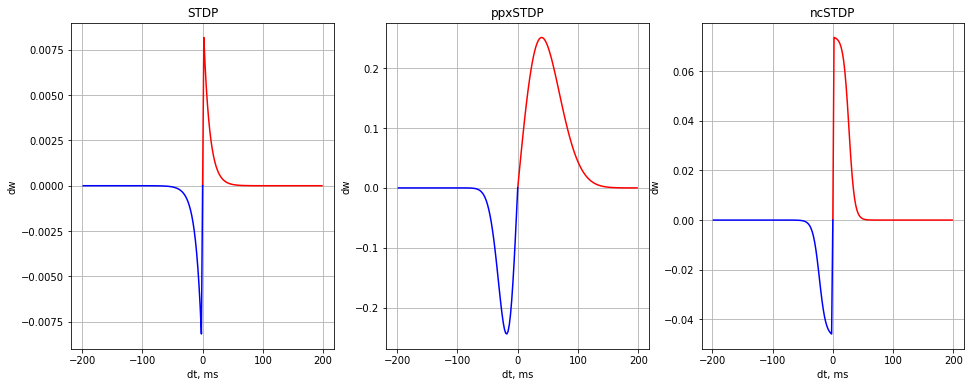

In [12]:
#draw plasticity rules

t0 = 10 #arbitrary
delta_t = torch.arange(0,200,2)

input_times = torch.as_tensor(t0).unsqueeze(0)

w = torch.ones(1,1) * 0.5 #arbitrary

data = []

headings = ["STDP", "ppxSTDP", "ncSTDP"]

for fname in headings:

    if fname == "STDP":
        rule = STDP()
    elif fname == "ppxSTDP":
        rule = ppxSTDP()
    elif fname == "ncSTDP":
        rule = ncSTDP()
    
    if fname == "STDP":

        y1 = [rule(input_times,input_times+dt).squeeze().numpy() for dt in delta_t]
        y2 = [rule(input_times+dt,input_times).squeeze().numpy() for dt in delta_t]
    else:
        y1 = [rule(input_times,input_times+dt,w).squeeze().numpy() for dt in delta_t]
        y2 = [rule(input_times+dt,input_times,w).squeeze().numpy() for dt in delta_t]
    
    data.append((delta_t, y1, y2))
    
fig = plt.figure(figsize=(16,6))

columns = len(headings)
rows = 1

ax = []
for i in range(1, columns*rows +1):
    ax.append(fig.add_subplot(rows, columns, i))
    plt.plot(data[i-1][0], data[i-1][1], color='red')
    plt.plot(-1*data[i-1][0], data[i-1][2], color='blue')
    ax[-1].set_title(headings[i-1])
    ax[-1].set_xlabel("dt, ms")
    ax[-1].set_ylabel("dw")
    ax[-1].grid()
plt.show()



